#  kaggle 자전거 수요 예측

- 프로그래머스 강의: https://programmers.co.kr/learn/courses/21/lessons/942#

- Bike Sharing Demand | Kaggle: https://www.kaggle.com/c/bike-sharing-demand

- You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

**Evaluation**     
Submissions are evaluated one the Root Mean Squared Logarithmic Error (RMSLE)


**Description**
- datetime - hourly date + timestamp      
- season -  1 = spring, 2 = summer, 3 = fall, 4 = winter       
- holiday - whether the day is considered a holiday       
- workingday - whether the day is neither a weekend nor holiday      
- weather 
   - 1: Clear, Few clouds, Partly cloudy, Partly cloudy       
   - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist      
   - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds      
   - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog      
- temp - temperature in Celsius      
- atemp - "feels like" temperature in Celsius      
- humidity - relative humidity        
- windspeed - wind speed          
- casual - number of non-registered user rentals initiated           
- registered - number of registered user rentals initiated          
- count - number of total rentals              

분류와 회귀중 회귀와 관련된 문제 + label 있는 지도학습 => 자전거 대여량을 예측하는 문제이기 때문에

# Load Dataset

In [1]:
# 필요한 라이브러리 import
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 노트북 안에 그래프 그리기 위해
%matplotlib inline

# 그래프에서 '격자'있는 (숫자 범위가 눈에 잘 띄도록) ggplot sytle 사용
plt.style.use('ggplot')

# 그래프 마이너스 폰트 깨지는 문제 대처
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
# 그래프에서 한글 폰트 깨지는 문제 대처
plt.rc("font", family="Malgun Gothic")
plt.rc("axes", unicode_minus=False)
from IPython.display import set_matplotlib_formats 
set_matplotlib_formats("retina")

In [3]:
train = pd.read_csv('train.csv', parse_dates = ['datetime'])   # parse_dates옵션: 지정한 열을 datetime type으로 지정해서 불러와줌
train.shape

(10886, 12)

In [4]:
test = pd.read_csv('test.csv', parse_dates = ['datetime'])
test.shape

(6493, 9)

# Feature Engineering

In [6]:
# datetime 나눠서/쪼개서 보기   # train
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
train['minute'] = train['datetime'].dt.minute
train['second'] = train['datetime'].dt.second
train['dayofweek'] = train['datetime'].dt.dayofweek
train.shape

(10886, 19)

In [7]:
# datetime 나눠서/쪼개서 보기   # test
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['hour'] = test['datetime'].dt.hour
test['minute'] = test['datetime'].dt.minute
test['second'] = test['datetime'].dt.second
test['dayofweek'] = test['datetime'].dt.dayofweek
test.shape

(6493, 16)

## 풍속 시각화

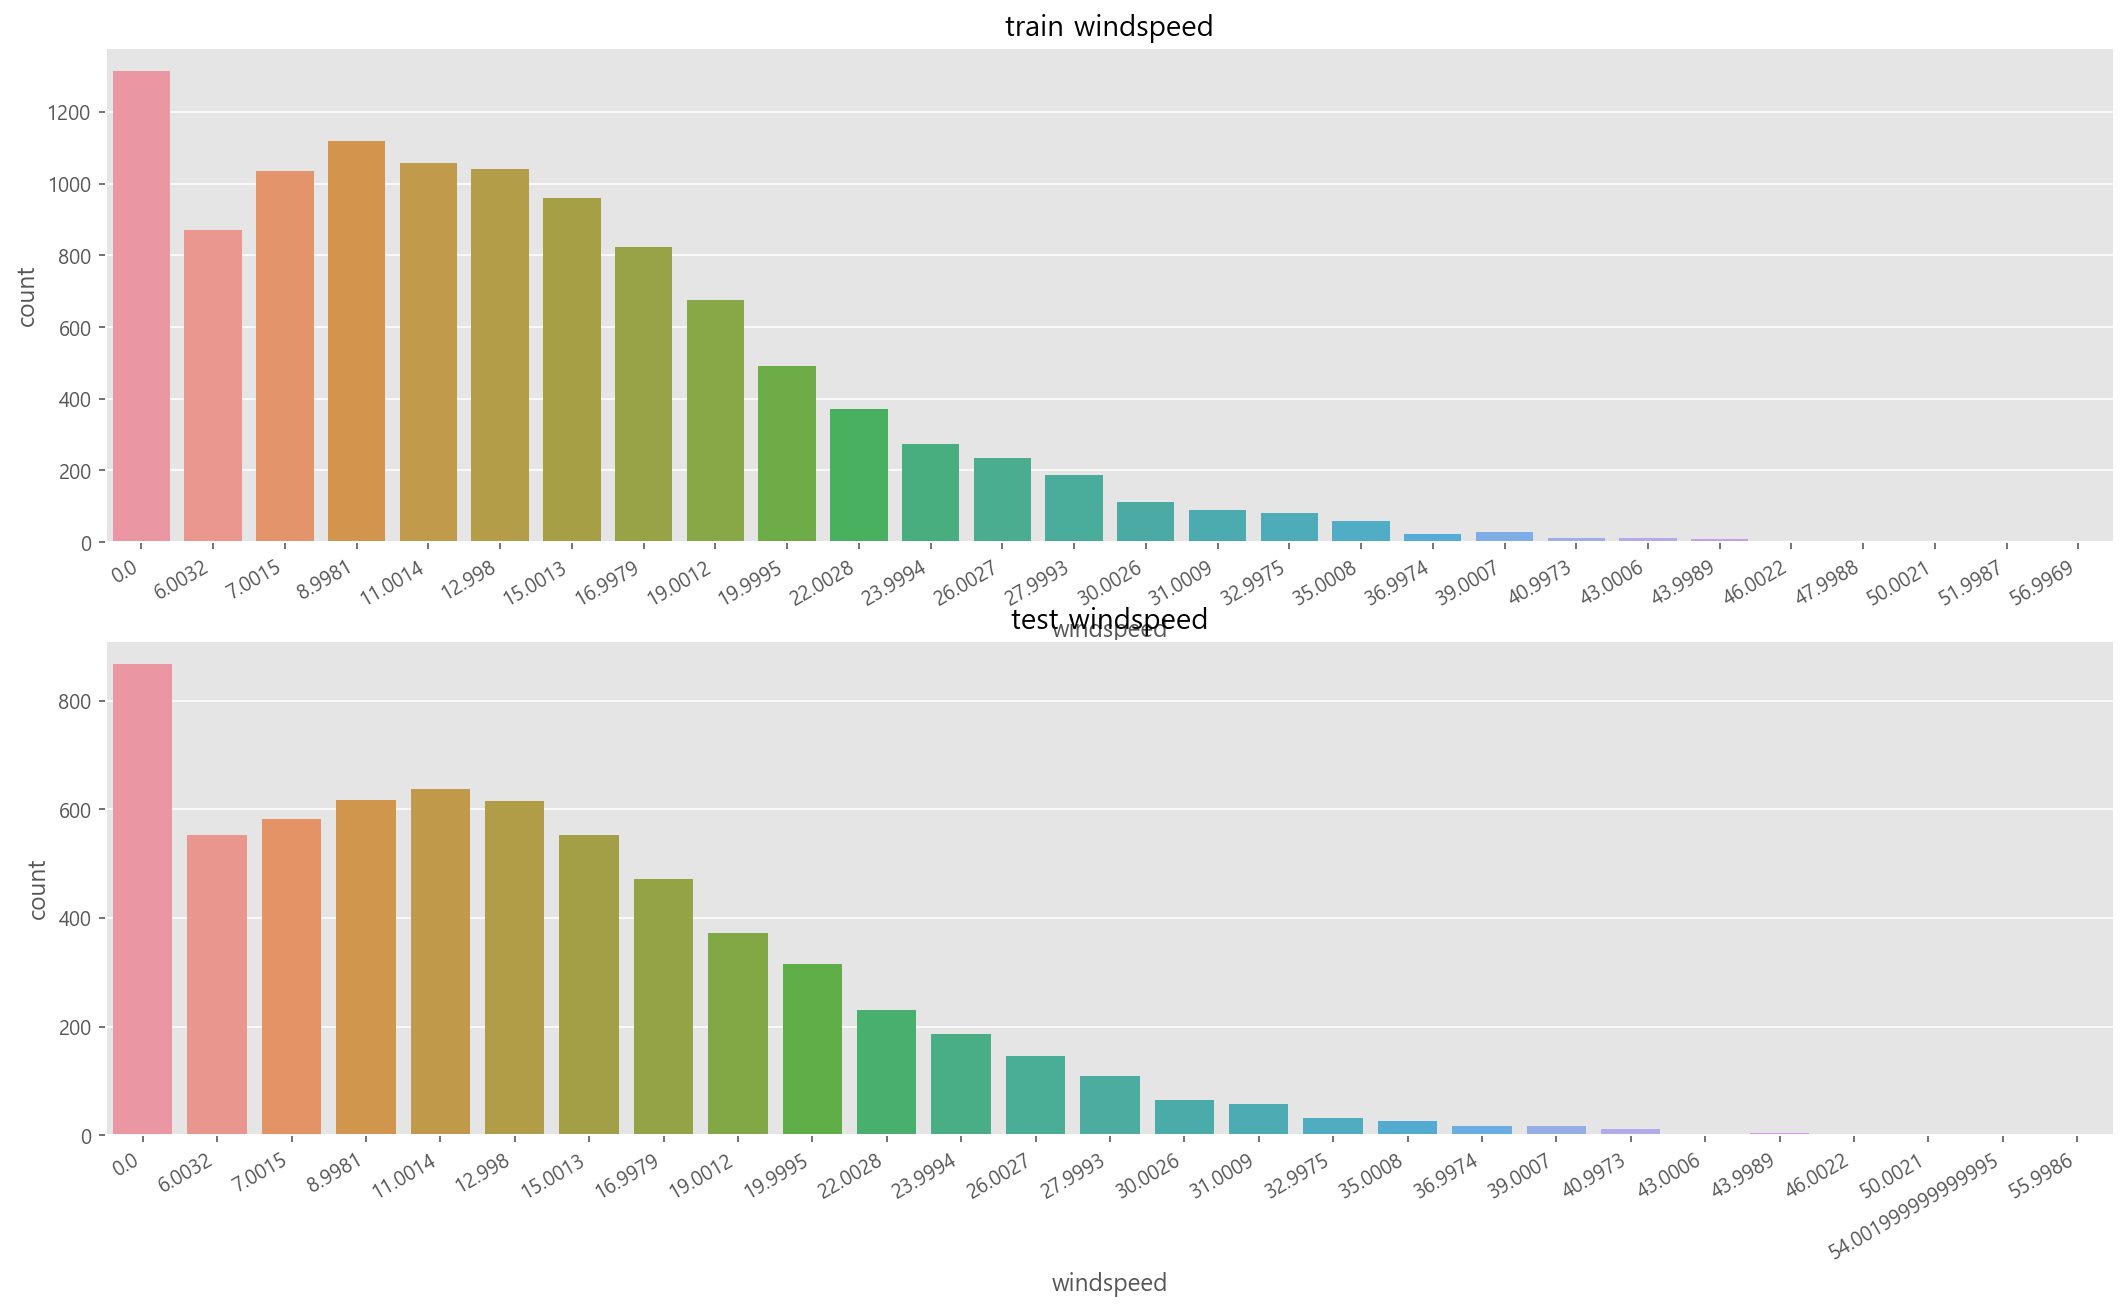

In [10]:
# data가 0에 많이 몰려있음 => 0 값 수정/보정 필요
fig, axes = plt.subplots(nrows=2)
fig.set_size_inches(18,10)

plt.sca(axes[0])
plt.xticks(rotation = 30, ha = 'right')
axes[0].set(ylabel='Count', title = 'train windspeed')
sns.countplot(data = train, x='windspeed', ax=axes[0])

plt.sca(axes[1])
plt.xticks(rotation = 30, ha = 'right')
axes[1].set(ylabel='Count', title = 'test windspeed')
sns.countplot(data = test, x='windspeed', ax=axes[1])

In [11]:
# 풍속 data가 0에 몰려있음
# 풍속의 0값에 특정 값을 넣어준다?
##  평균을 구해 일괄적으로 넣는다. -> 하지만, 예측의 정확도를 높이는 데 도움이 될 것 같지 않음
##  train.loc[train['windspeed'] == 0, 'windspeed'] = train['windspeed'].mean()
##  test.loc[test['windspeed'] == 0, 'windspeed'] = test['windspeed'].mean()

In [13]:
# 풍속이 0인것과 아닌것 세트 나눠주기
trainWind0 = train.loc[train['windspeed'] == 0]
trainWindNot0 = train.loc[train['windspeed']!= 0]
print(trainWind0.shape)
print(trainWindNot0.shape)

(1313, 19)
(9573, 19)


In [21]:
# 풍속이 0인 값을 머신러닝 예측값으로 대체
# 풍속이 0인것: test set, 풍속이 0이 아닌 것: train set
from sklearn.ensemble import RandomForestClassifier

# 머신러닝 랜덤 포레스트 분류기 학습 함수
def predict_windspeed(data):
    
    # data를 받으면 풍속이 0인것과 아닌 것을 나누어 준다.
    dataWind0 = data.loc[data['windspeed'] == 0]
    dataWindNot0 = data.loc[data['windspeed'] != 0]
    
    # 풍속을 예측할 feature들을 지정해준다
    wCol = ['season','weather','humidity','month','temp','year','atemp']
    
    # 풍속이 0이 아닌 데이터들의 타입을 스트링으로 바꿔준다.   #범주형 data처럼 취급해주길 바래서?
    dataWindNot0['windspeed'] = dataWindNot0['windspeed'].astype('str')
    
    # 랜덤포레스트 분류기를 사용한다.
    rfModel_wind = RandomForestClassifier()
    
    #wCol에 있는 feature들의 값을 바탕으로, 풍속을 학습시킨다.   #fit
    rfModel_wind.fit(dataWindNot0[wCol], dataWindNot0['windspeed'])
    
    # 학습한 값을 바탕으로, 풍속이 0으로 된 데이터의 풍속을 예측한다.
    wind0Values = rfModel_wind.predict(X = dataWind0[wCol])
    
    # 값을 모두 예측한 후 비교를 위해, 예측한 값을 넣어 줄 데이터 프레임 새로 생성
    predictWind0 = dataWind0
    predictWindNot0 = dataWindNot0
    
    # 값이 0으로된 풍속에 대해, 예측한 값을 넣어준다.
    predictWind0['windspeed'] = wind0Values
    
    # dataWindNot0 0이 아닌 풍속이 있는 데이터 프레임에, 예측한 값이 있는 데이터프레임을 합쳐준다.   # append
    data = predictWindNot0.append(predictWind0)
    
    # 풍속의 데이터 타입을 float로 지정해준다.
    data['windspeed'] = data['windspeed'].astype('float')
    
    data.reset_index(inplace = True)
    data.drop('index', inplace=True, axis = 1)
    
    return data

In [27]:
# 위에서 만든 함수로, 0값 조정/대체해주기
train = predict_windspeed(train)
# test = predict_windspeed(test)

ValueError: Found array with 0 sample(s) (shape=(0, 7)) while a minimum of 1 is required.

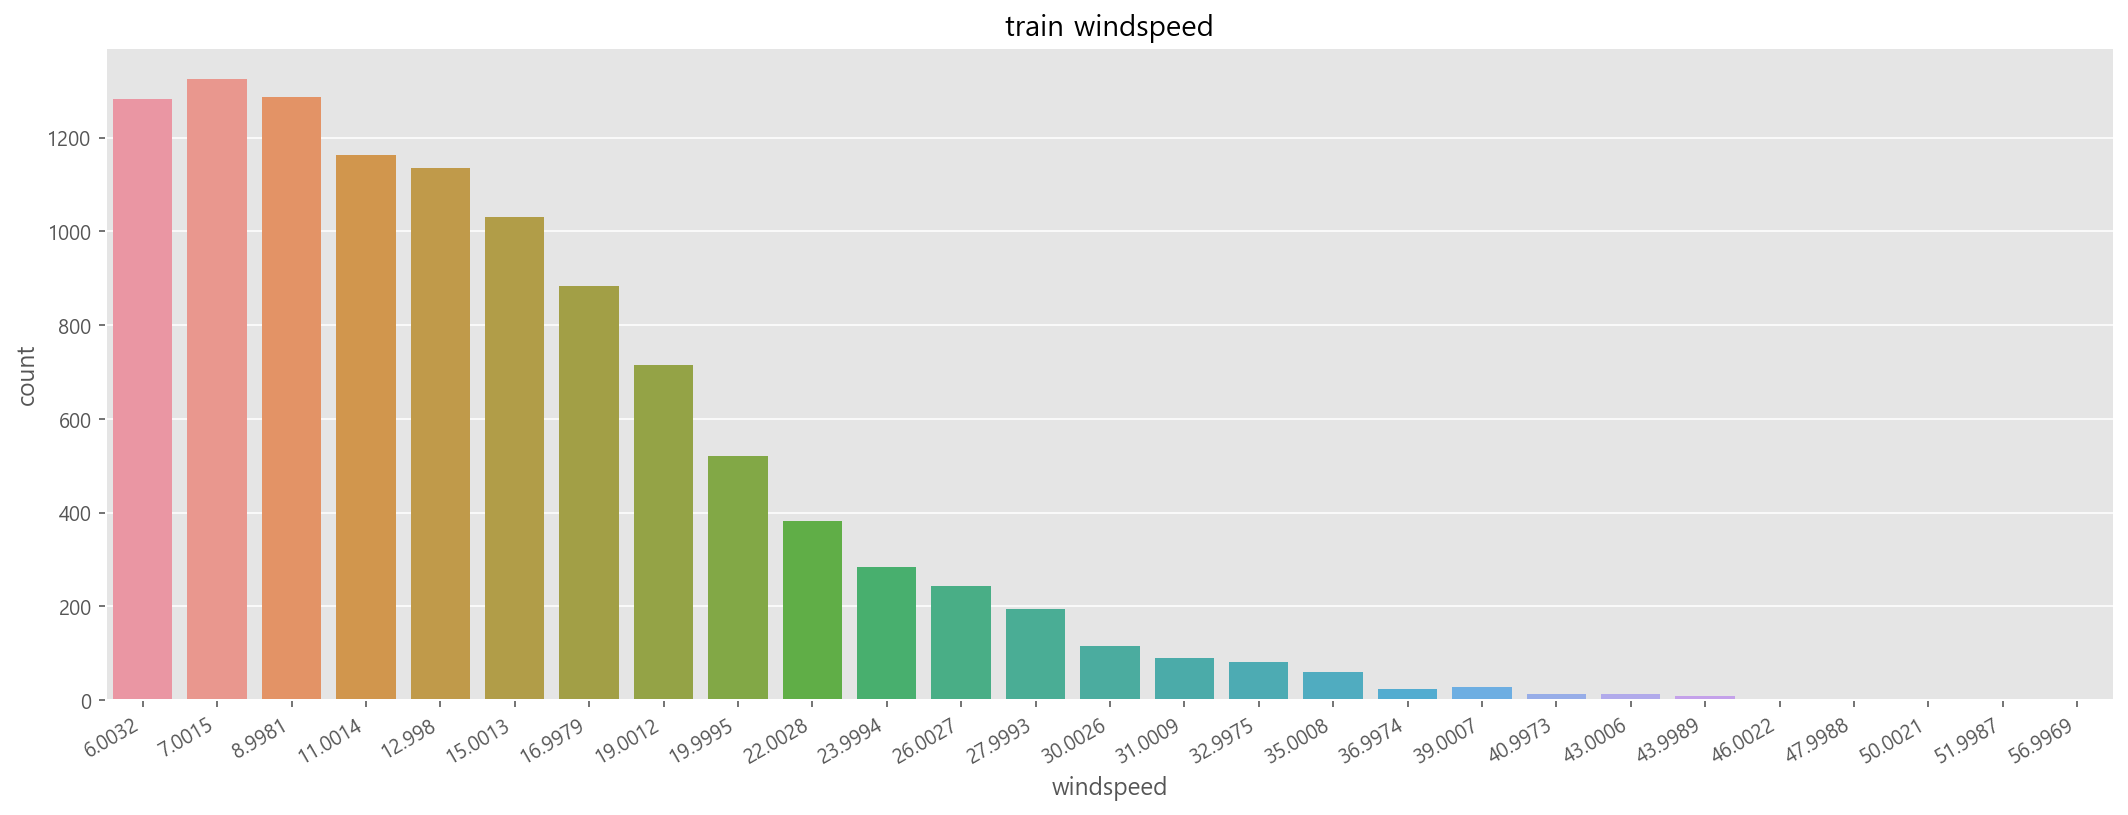

In [26]:
# windspeed의 0값을 조정한 data 시각화
fig, ax1 = plt.subplots()
fig.set_size_inches(18,6)

plt.sca(ax1)
plt.xticks(rotation=30, ha = 'right')
ax1.set(ylabel = 'Count', title = 'train windspeed')
sns.countplot(data = train, x = 'windspeed', ax= ax1)

0 데이터가 예측값으로 대체되었음

# Feature Selection
- 신호와 잡음을 구분해야함
- feature가 많다고 해서 무조건 좋은 성능을 내는 것은 아님
- feature를 하나씩 추가하고 변경해가면서, 성능이 좋지 않은/중요하지 않은 feature는 제거해야함

- 원래는 숫자형변수, 범주형 변수 나눠서, 범주형 변수는 onehotencoding 등으로 코딩해줘야함
- 하지만, 일단 범주형 변수를 '카테고리' type으로 일괄 변경해주자

In [28]:
# 연속형 feature와 범주형 feature
# 연속형 feature = ['temp','humidity','windspeed','atemp']

# 범주형 feature의 type을 'category'로 변경해주자
categorical_feature_names = ['season','holiday','workingday','weather','dayofweek','month','year','hour']

for var in categorical_feature_names:
    train[var] = train[var].astype('category')
    test[var] = test[var].astype('category')

In [29]:
# 예측에 쓰일 feature 지정/선택
feature_names = ['season','weather','temp','atemp','humidity','windspeed','year','hour','dayofweek','holiday','workingday']
feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [30]:
# 선택한 feature들로만 구성된, 예측에 쓰일 train_set 생성
X_train = train[feature_names]

print(X_train.shape)
X_train.head()

(10886, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,2,9.84,12.880,75,6.0032,2011,5,5,0,0
1,1,1,15.58,19.695,76,16.9979,2011,10,5,0,0
2,1,1,14.76,16.665,81,19.0012,2011,11,5,0,0
3,1,1,17.22,21.210,77,19.0012,2011,12,5,0,0
4,1,2,18.86,22.725,72,19.9995,2011,13,5,0,0


In [31]:
# 선택한 feature들로만 구성된, 예측에 쓰일 test_set 생성
X_test = test[feature_names]

print(X_test.shape)
X_test.head()

(6493, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,26.0027,2011,0,3,0,1
1,1,1,10.66,13.635,56,0.0000,2011,1,3,0,1
2,1,1,10.66,13.635,56,0.0000,2011,2,3,0,1
3,1,1,10.66,12.880,56,11.0014,2011,3,3,0,1
4,1,1,10.66,12.880,56,11.0014,2011,4,3,0,1


In [32]:
# y_label 지정
label_name = 'count'  # 예측해야할 값이 count니까

y_train = train[label_name]  # count값을 y_train에 넣어줌

print(y_train.shape)
y_train.head()

(10886,)


0     1
1    36
2    56
3    84
4    94
Name: count, dtype: int64

# RandomForest

In [34]:
from sklearn.ensemble import RandomForestRegressor

max_depth_list = []

model = RandomForestRegressor(n_estimators = 100,    # n_estimators 값을 올릴 수록 예측력이 좋아지지만, 그만큼 시간이 오래걸림
                              n_jobs = -1, 
                              random_state = 0)

model

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [42]:
# rmsle 계산 함수
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values):
    # 넘파이로 배열 형태를 바꿔준다.
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    # 예측값과 실제 값에 1을 더하고, log를 씌워준다.
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱해준다.
    difference = log_predict - log_actual
    # difference = (log_predict - log_actual) ** 2
    difference = np.square(difference)
    
    # 평균내기
    mean_difference = difference.mean()
    
    # 다시 루트를 씌운다
    score = np.sqrt(mean_difference)
    
    return score
remsle_scorer = make_scorer(rmsle)
remsle_scorer

make_scorer(rmsle)

In [39]:
# k-fold 교차검즘에서, 최적의 k-fold 반복값 정하기  #k #cv
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits = 10, shuffle = True, random_state = 0)

In [43]:
# 교차검증값  :  0.33040
# score 계산할 때 걸린 시간 time 찍는거 추가: %time
%time score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring = remsle_scorer)
score = score.mean()
# 0에 근접할 수록 좋은 데이터
print('Score = {0:.5f}'.format(score))

Wall time: 24.6 s
Score = 0.33040


## train, predict

In [44]:
# 학습 시키기: .fit() - feature와 label을 넣어주면, 알아서 학습함
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [45]:
# 예측: .predict()
predictions = model.predict(X_test)

print(predictions.shape)
predictions[0:10]

(6493,)


array([ 12.4 ,   5.19,   4.18,   3.47,   3.19,   6.57,  38.1 , 105.53,
       236.79, 136.85])

[Text(0.5, 1.0, 'test')]

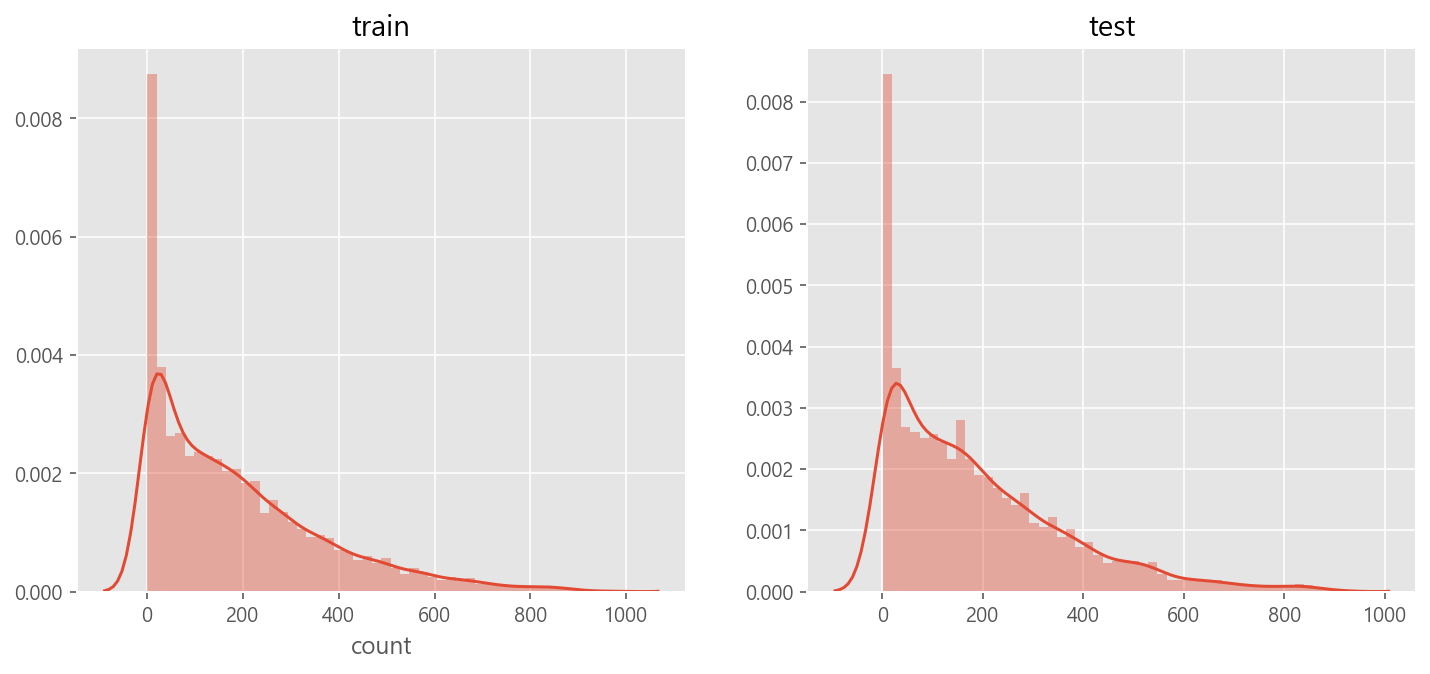

In [47]:
# 예측 data 시각화: distplot
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12,5)

sns.distplot(y_train, ax=ax1, bins=50)
ax1.set(title='train')

sns.distplot(predictions, ax=ax2, bins=50)
ax2.set(title='test')

- 0 에 몰려있음      
- train, test 분포 형태 나름 비슷

# Submit

In [49]:
submission = pd.read_csv('sampleSubmission.csv')
submission

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0
...,...,...
6488,2012-12-31 19:00:00,0
6489,2012-12-31 20:00:00,0
6490,2012-12-31 21:00:00,0
6491,2012-12-31 22:00:00,0


In [50]:
submission['count'] = predictions   # count 컬럼에 predictions 값들 넣어주기

print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,12.40
1,2011-01-20 01:00:00,5.19
2,2011-01-20 02:00:00,4.18
3,2011-01-20 03:00:00,3.47
4,2011-01-20 04:00:00,3.19


In [51]:
submission.to_csv('Score_{0:.5f}_submission.csv'.format(score), index = False)  